In [1]:
import polars as pl
import numpy as np
from PIL import Image
import requests
import time
import io
from IPython.display import display, Image as IPythonImage

In [2]:
df = pl.read_parquet("/Users/maxwoolf/Downloads/mtg_embeddings_2d-3.parquet")

In [3]:
test_card_name = "Lightning Helix"

query_row = df.filter(pl.col("name") == test_card_name)
query_row

name,scryfallId,manaCost,type,text,power,toughness,loyalty,rarities,sets,embedding,x_2d,y_2d
str,str,str,str,str,str,str,str,list[enum],list[enum],"array[f32, 768]",f32,f32
"""Lightning Helix""","""4101e3fe-b0e7-4f0f-b9ac-9b61a4…","""{R}{W}""","""Instant""","""~ deals 3 damage to any target…",null,null,null,"[""uncommon"", ""rare""]","[""PRM"", ""RAV"", … ""MKM""]","[0.00352, -0.043314, … 0.013035]",0.250061,3.91687


## Test Image retrieval from Scryfall API

- https://scryfall.com/docs/api
- https://scryfall.com/docs/api/images


## Test basic HTTP request for card info using ID


In [4]:
query_card_id = query_row["scryfallId"].item()
query_card_id

'4101e3fe-b0e7-4f0f-b9ac-9b61a4d628b3'

In [5]:
SCRYFALL_URI = "https://api.scryfall.com"

headers = {"User-Agent": "Related Card Image/1.0", "Accept": "*/*"}
card_uri = f"{SCRYFALL_URI}/cards/{query_card_id}"

r = requests.get(card_uri, headers=headers)

r.json()["image_uris"]

{'small': 'https://cards.scryfall.io/small/front/4/1/4101e3fe-b0e7-4f0f-b9ac-9b61a4d628b3.jpg?1706242208',
 'normal': 'https://cards.scryfall.io/normal/front/4/1/4101e3fe-b0e7-4f0f-b9ac-9b61a4d628b3.jpg?1706242208',
 'large': 'https://cards.scryfall.io/large/front/4/1/4101e3fe-b0e7-4f0f-b9ac-9b61a4d628b3.jpg?1706242208',
 'png': 'https://cards.scryfall.io/png/front/4/1/4101e3fe-b0e7-4f0f-b9ac-9b61a4d628b3.png?1706242208',
 'art_crop': 'https://cards.scryfall.io/art_crop/front/4/1/4101e3fe-b0e7-4f0f-b9ac-9b61a4d628b3.jpg?1706242208',
 'border_crop': 'https://cards.scryfall.io/border_crop/front/4/1/4101e3fe-b0e7-4f0f-b9ac-9b61a4d628b3.jpg?1706242208'}

Test querying image directly.


In [6]:
IMAGES_URI = "https://cards.scryfall.io/"


def get_card_image(scryfallId, size="normal"):
    image_uri = (
        f"{IMAGES_URI}/{size}/front/{scryfallId[0]}/{scryfallId[1]}/{scryfallId}.jpg"
    )

    # https://stackoverflow.com/a/29328036
    img_data = requests.get(image_uri, headers=headers, stream=True).raw
    image = Image.open(img_data)

    time.sleep(0.2)

    return image

Image is too high-rez and inflates the size of Jupyter Notebooks, so convert to WEBP and reduce the quality a bit.


In [7]:
def display_jupyter(img, quality=50):
    if img.mode in ("RGBA", "LA") or (img.mode == "P" and "transparency" in img.info):
        img = img.convert("RGB")

    buffer = io.BytesIO()
    img.save(buffer, format="WEBP", quality=quality)
    buffer.seek(0)

    display(IPythonImage(data=buffer.getvalue()))

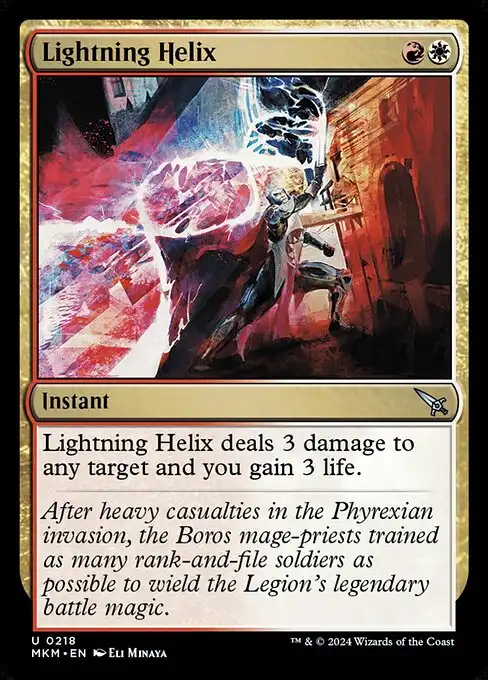

In [8]:
display_jupyter(get_card_image(query_card_id))

## Composite Images


In [9]:
query_embed = query_row["embedding"].to_numpy(allow_copy=False)[0]
query_embed.shape

(768,)

In [10]:
embeddings = df["embedding"].to_numpy(allow_copy=False)
embeddings.shape

(32254, 768)

In [11]:
def fast_dot_product(query, matrix, k=3):
    dot_products = query @ matrix.T

    idx = np.argpartition(dot_products, -k)[-k:]
    idx = idx[np.argsort(dot_products[idx])[::-1]]

    score = dot_products[idx]

    return idx, score

In [12]:
idx, _ = fast_dot_product(query_embed, embeddings, k=5)
df[idx][1:]

name,scryfallId,manaCost,type,text,power,toughness,loyalty,rarities,sets,embedding,x_2d,y_2d
str,str,str,str,str,str,str,str,list[enum],list[enum],"array[f32, 768]",f32,f32
"""Warleader's Helix""","""989f8049-c4d2-4729-b35f-7bd7d8…","""{2}{R}{W}""","""Instant""","""~ deals 4 damage to any target…",null,null,null,"[""uncommon"", ""rare""]","[""PRM"", ""DGM"", … ""UMA""]","[-0.0187, -0.041273, … 0.025631]",0.269287,3.854736
"""Lightning Bolt""","""77c6fa74-5543-42ac-9ead-0e890b…","""{R}""","""Instant""","""~ deals 3 damage to any target…",null,null,null,"[""common"", ""uncommon"", … ""special""]","[""LEA"", ""LEB"", … ""CLU""]","[0.006573, -0.00919, … 0.027299]",0.228607,3.952759
"""Lightning Blast""","""2ca1ead8-44d8-406f-af36-276f41…","""{3}{R}""","""Instant""","""~ deals 4 damage to any target…",null,null,null,"[""common"", ""uncommon""]","[""TMP"", ""6ED"", … ""TPR""]","[0.006088, -0.00564, … 0.021717]",0.234894,3.94104
"""Lightning Strike""","""30077b49-b825-4dbb-a0c7-f3992f…","""{1}{R}""","""Instant""","""~ deals 3 damage to any target…",null,null,null,"[""common"", ""uncommon"", ""rare""]","[""THS"", ""M15"", … ""DFT""]","[0.029171, -0.009553, … 0.025874]",0.195282,3.916504


In [13]:
# Generated w/ Claude 3.5 Sonnet w/ slight tweaks


def create_composite(left_img, right_imgs, final_size=(488 * 2, 680)):
    """
    Create a composite image with 5 images:
    - Left half: one large image
    - Right half: 4 equally sized images in quadrants

    Args:
        left_image_path (str): PIL Image for the left half
        right_images_paths (list): List of 4 PIL Images for the right quadrant images
        final_size (tuple): Final dimensions of the composite image (width, height)
    """

    # Create a new blank image with white background
    composite = Image.new("RGB", final_size, "white")

    # Calculate dimensions
    half_width = final_size[0] // 2
    half_height = final_size[1] // 2

    try:
        # Resize maintaining aspect ratio
        left_img.thumbnail((half_width, final_size[1]))
        # Paste left image
        composite.paste(left_img, (0, 0))

        # Process right quadrant images
        quadrant_positions = [
            (half_width, 0),  # top-left
            (half_width + half_width // 2, 0),  # top-right
            (half_width, half_height),  # bottom-left
            (half_width + half_width // 2, half_height),  # bottom-right
        ]

        for img, position in zip(right_imgs, quadrant_positions):
            # Resize maintaining aspect ratio
            img.thumbnail((half_width // 2, half_height))
            # Paste into position
            composite.paste(img, position)

        return composite

    except Exception as e:
        print(f"Error creating composite: {str(e)}")
        raise

In [14]:
def composite_related_cards(card_name):
    query_card = df.filter(pl.col("name") == card_name)
    query_card_id = query_card["scryfallId"].item()
    query_embed = query_card["embedding"].to_numpy(allow_copy=False)[0]

    idx, _ = fast_dot_product(query_embed, embeddings, k=5)

    related_card_ids = df[idx[1:]]["scryfallId"].to_list()

    # get base card images
    base_img = get_card_image(query_card_id, "normal")
    related_imgs = [get_card_image(card_id, "normal") for card_id in related_card_ids]

    composite = create_composite(base_img, related_imgs)
    display_jupyter(composite)

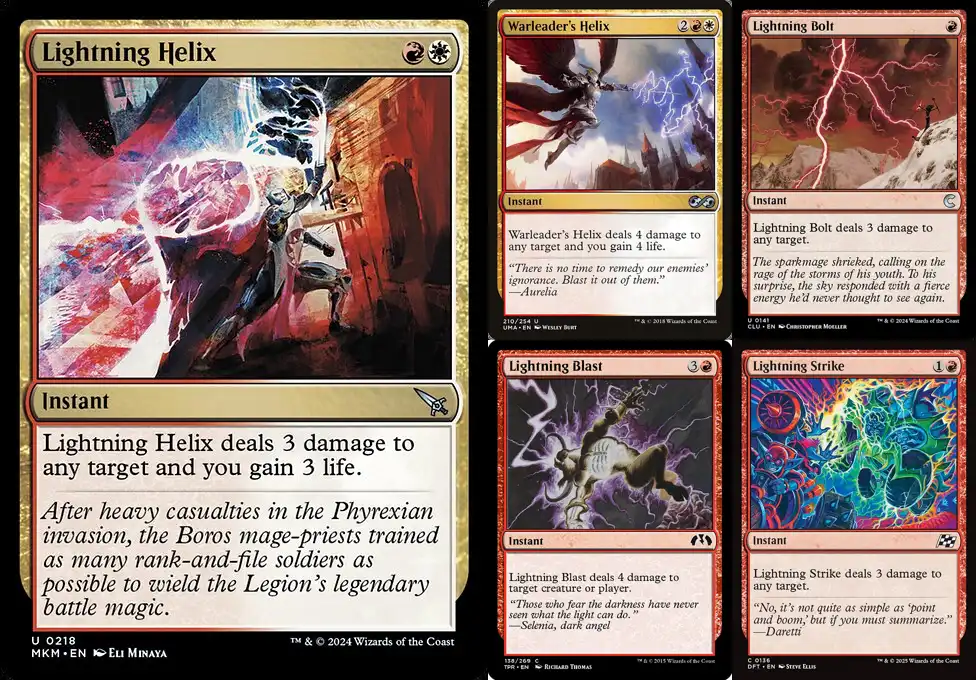

In [15]:
composite_related_cards(test_card_name)

## Test More Cards


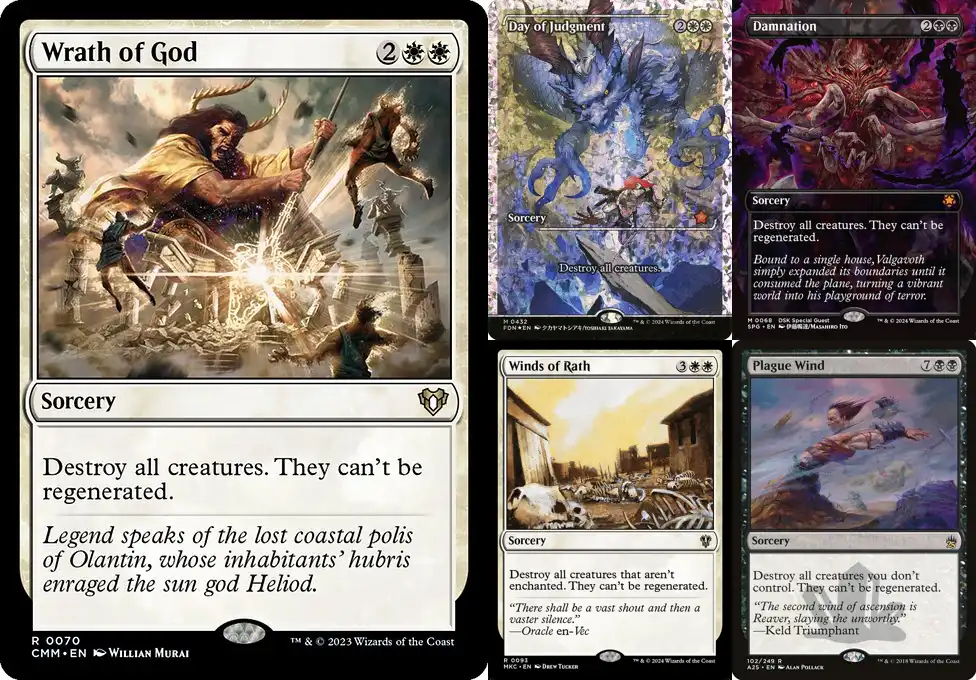

In [16]:
composite_related_cards("Wrath of God")

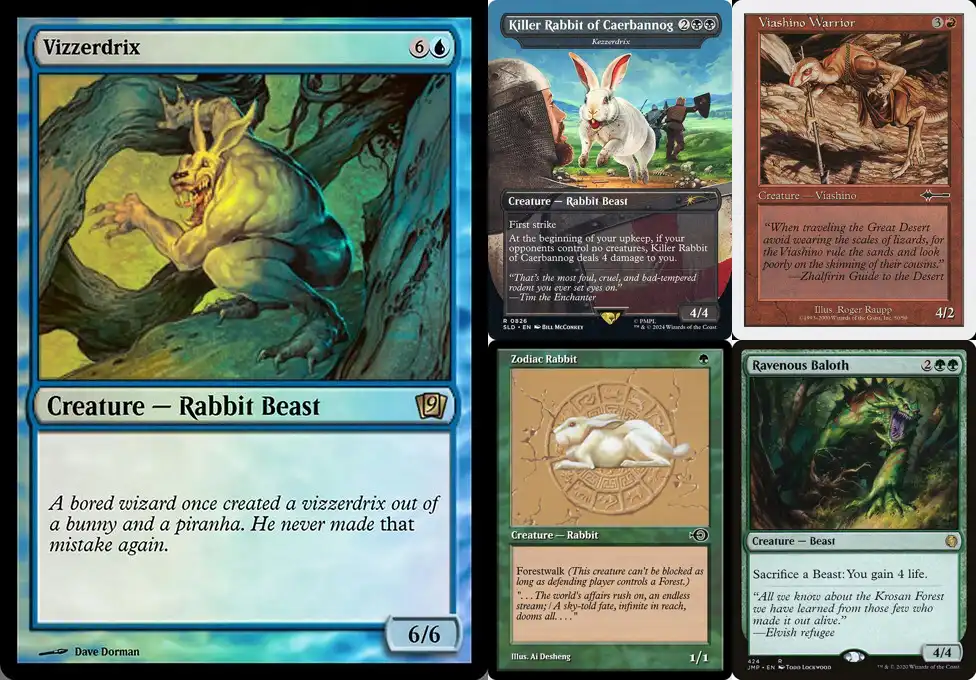

In [17]:
composite_related_cards("Vizzerdrix")

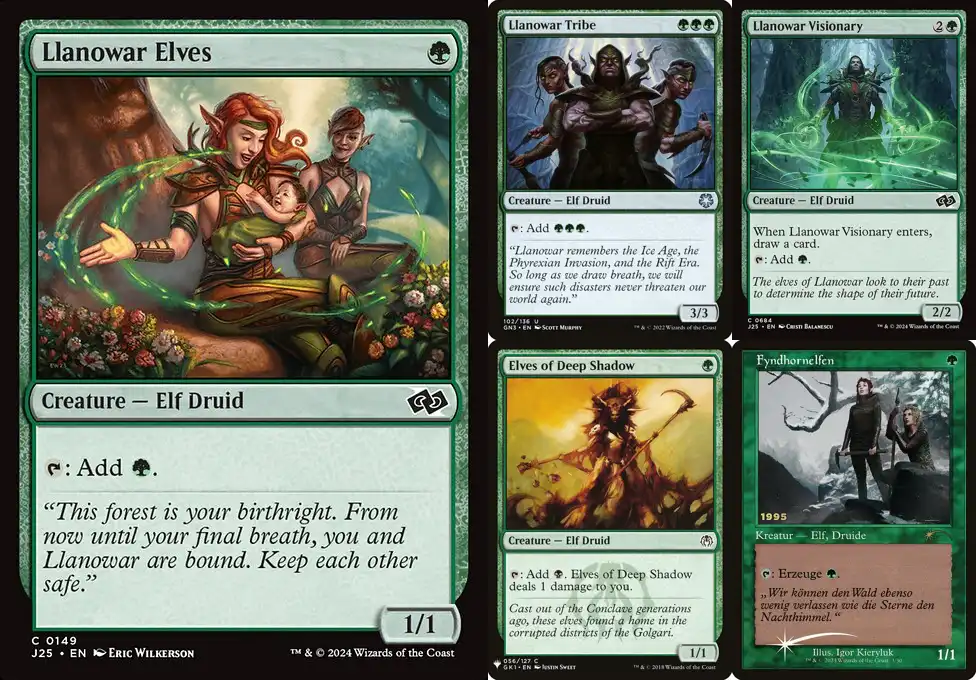

In [18]:
composite_related_cards("Llanowar Elves")